# Import data and dtm creation

## Import

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import random
import time
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from IPython.display import IFrame
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import os
from sklearn.ensemble import RandomForestClassifier
from google.colab import files
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

The dataset is a public set of comments collected for spam research. It has five datasets composed by 1,956 real messages extracted from five videos that were among the 10 most viewed on the collection period.

The data can be downloaded directly from the following website:
https://www.kaggle.com/datasets/lakshmi25npathi/images

For convenience, I uploaded the files to my personal GitHub repository, from which they are downloaded for analysis.

There are five datasets, each containing comments from a specific YouTube video.
In this first code cell, I download and merge them into a single dataset.


In [2]:
base_url = "https://raw.githubusercontent.com/PietroParenti/yt-comments-classifier/main/"

file_names = [
    "Youtube01-Psy.csv",
    "Youtube02-KatyPerry.csv",
    "Youtube03-LMFAO.csv",
    "Youtube04-Eminem.csv",
    "Youtube05-Shakira.csv"
]

urls = [base_url + fname for fname in file_names]

dataframes = [pd.read_csv(url) for url in urls]

df_original = pd.concat(dataframes, ignore_index=True)

df_original.loc[df_original.index<5,:]

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


The dataset consists of 1,956 comments. For each comment, the following information is provided:

*   The user ID

*   The username of the author

*   The publication date

*   The comment text

*   The spam classification label

The most relevant variables for our analysis will be the last two: the comment text and its classification label.












In [3]:
df = df_original

print("="*50)
print("Number of rows: ")
print(df.shape[0])

print("\n" + "="*50)
print("Number of columns: ")
print(df.shape[1])

print("\n" + "="*50)
print('Column names')
print(list(df.columns))

Number of rows: 
1956

Number of columns: 
5

Column names
['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS']


Missing Values Check

In [4]:
print("="*50)
for col in ['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS']:
    missingValueMask = df[col].isna()
    num_missing = missingValueMask.sum()

    if num_missing == 0:
        print(f'No missing values in column {col}')
    else:
        print(f'{num_missing} missing values in column {col}')

No missing values in column COMMENT_ID
No missing values in column AUTHOR
245 missing values in column DATE
No missing values in column CONTENT
No missing values in column CLASS


Presence of missing values only in date column. The date column will not be used in analisys, so NA are not removed

Class Distribution: class is the response variable.

*  1 for spam comment

*  0 for no spam content

In [5]:
print("="*50)
print("Observation count per class:")
print(df['CLASS'].value_counts())
print()

print("\n" + "="*50)
print("Observation percentage per class:")
print(df['CLASS'].value_counts(normalize=True) * 100)

Observation count per class:
CLASS
1    1005
0     951
Name: count, dtype: int64


Observation percentage per class:
CLASS
1    51.380368
0    48.619632
Name: proportion, dtype: float64


The dataset is unbalanced. To implement the ml algoritms is better to have balanced data.

Downsampling is applied by reducing the number of instances in the majority class, with the goal of creating a balanced dataset.



In [6]:
df_unbalanced=df

random.seed(1)

def underSample2Min(df, labelName):
    vc = df.loc[:,labelName].value_counts()
    lab2freq = dict(zip(vc.index.tolist(), vc.values.tolist()))
    minfreq = min(lab2freq.values())
    idxSample=[]
    for selectedLabel, actualFreq in lab2freq.items():
        selIndexes=df.loc[df.loc[:,labelName]==selectedLabel, :].sample(n=minfreq).index.tolist()
        idxSample+=selIndexes
    idxSample.sort()

    df2 = df.loc[idxSample, :]
    df2 = df2.reset_index()
    return df2

df = underSample2Min(df_unbalanced, 'CLASS')

print("="*50)
print("Observation count per class:")
print(df['CLASS'].value_counts())

Observation count per class:
CLASS
1    951
0    951
Name: count, dtype: int64


In order to implement ml algoritms is correct to split the dataset into train and test

In [7]:
xAll = df.loc[:,'CONTENT']
yAll = df.loc[:,'CLASS']
print('type(xAll)', type(xAll), 'xAll.shape', xAll.shape)
print('type(yAll)', type(yAll), 'xAll.shape', yAll.shape)
print()

xTrainVec, xTestVec, yTrain, yTest = train_test_split(
    xAll, yAll,
    test_size=0.30,
    random_state=0,
    stratify=yAll
)

varDi = {'xAll':xAll, 'yAll':yAll, 'xTrainVec':xTrainVec, 'xTestVec':xTestVec, 'yTrain':yTrain, 'yTest':yTest}
for varName, var in varDi.items(): # return a list of key-value pairs
  print(varName, var.shape)

xTrain = list(xTrainVec)
xTest = list(xTestVec)

type(xAll) <class 'pandas.core.series.Series'> xAll.shape (1902,)
type(yAll) <class 'pandas.core.series.Series'> xAll.shape (1902,)

xAll (1902,)
yAll (1902,)
xTrainVec (1331,)
xTestVec (571,)
yTrain (1331,)
yTest (571,)


## DTM unsupervised

Document Term Matrix creation.
A document-term matrix (DTM) is a structured representation of text data, where rows correspond to documents and columns to terms (words), with each cell indicating the frequency (or presence) of a term in a document.

In [8]:
vectorizer = CountVectorizer()

dtm = vectorizer.fit_transform(df["CONTENT"])

# converto in DataFrame con i nomi delle parole come colonne
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

print(dtm_df.head(3))

   00  000  002  018  02  034  047000  05  053012  0687119038  ...  ｃｏｍｍｅｎｔ  \
0   0    0    0    0   0    0       0   0       0           0  ...        0   
1   0    0    0    0   0    0       0   0       0           0  ...        0   
2   0    0    0    0   0    0       0   0       0           0  ...        0   

   ｄａｍｎ  ｅｂａｙ  ｆａｎｃy  ｈｔｔｐ  ｉｓ  ｓｈｏｅｃｏｌｌｅｃｔｏｒ314  ｔｈｉｓ  ｕｓｒ  ｗｗｗ  
0     0     0      0     0   0                 0     0    0    0  
1     0     0      0     0   0                 0     0    0    0  
2     0     0      0     0   0                 0     0    0    0  

[3 rows x 4292 columns]


Adding the classification column to the dtm

In [9]:
dtm_df["spam"] = df["CLASS"]

print(dtm_df["spam"].head(3))

0    1
1    1
2    1
Name: spam, dtype: int64


Descriptive analyses and the development of the initial, simpler machine learning models are performed in R. Therefore, this code cell exports the document-term matrix for further analysis in R.

Uncomment this cell if you need to export the dtm

In [ ]:
#dtm_df.to_csv("dtm_per_R.csv", index=False)
#files.download("dtm_per_R.csv")

## DTM supervised

The previous DTM was created in an unsupervised manner. We now attempt to improve the dataset by refining the text preprocessing step using the following CountVectorizer options:

* stop_words='english': removes common English stopwords that carry little semantic value (e.g., "the", "and", "is").

* token_pattern=r'(?u)(?:#|@)?\b[^\W\d]+\b': defines the pattern for valid tokens, allowing for hashtags and mentions (since the texts are from social media), and excluding numbers and punctuation.

* max_df=0.9: excludes terms that appear in more than 90% of documents, as they are likely too frequent to be informative.

* min_df=2: includes only terms that appear in at least 2 documents, removing rare words that may introduce noise.

In [10]:
vectorizer = CountVectorizer(
    stop_words='english',  # Stopword inglese
    token_pattern=r'(?u)(?:#|@)?\b[^\W\d]+\b',
    max_df=0.9,                       # Rimuovi termini in >90% dei documenti
    min_df=2,                         # Termini in almeno 2 documenti
    binary=False                      # Conteggi, non presenza/assenza
)

dtm2 = vectorizer.fit_transform(df["CONTENT"])

# converto in DataFrame con i nomi delle parole come colonne
dtm2_df = pd.DataFrame(dtm2.toarray(), columns=vectorizer.get_feature_names_out())

print(dtm2_df.head(3))

   #home  #share  #soundsofsunday  _  __  _trksid  able  abomination  \
0      0       0                0  0   0        0     0            0   
1      0       0                0  0   0        0     0            0   
2      0       0                0  1   0        0     0            0   

   absolutely  abusive  ...  yo  young  youtu  youtube  youtuber  youtubers  \
0           0        0  ...   0      0      0        0         0          0   
1           0        0  ...   0      0      0        0         0          0   
2           0        0  ...   0      0      0        0         0          0   

   zombie  zonepa  ஜ  강남스타일  
0       0       0  0      0  
1       0       0  0      0  
2       0       0  0      0  

[3 rows x 1245 columns]


Adding the classification column to the dtm

In [11]:
dtm2_df["spam"] = df["CLASS"]

print(dtm2_df["spam"].head(3))

0    1
1    1
2    1
Name: spam, dtype: int64


Descriptive analyses and the development of the initial, simpler machine learning models are performed in R. Therefore, this code cell exports the document-term matrix for further analysis in R.

Uncomment this cell if you need to export the dtm

In [ ]:
#dtm2_df.to_csv("dtm2_per_R.csv", index=False)
#files.download("dtm2_per_R.csv")

### Word Cloud

Not relevant for the analysis — feel free to skip if not interested.



Word clouds showing the most frequently used terms in YouTube comments, separated by spam and non-spam classes.



Spam comments word cloud

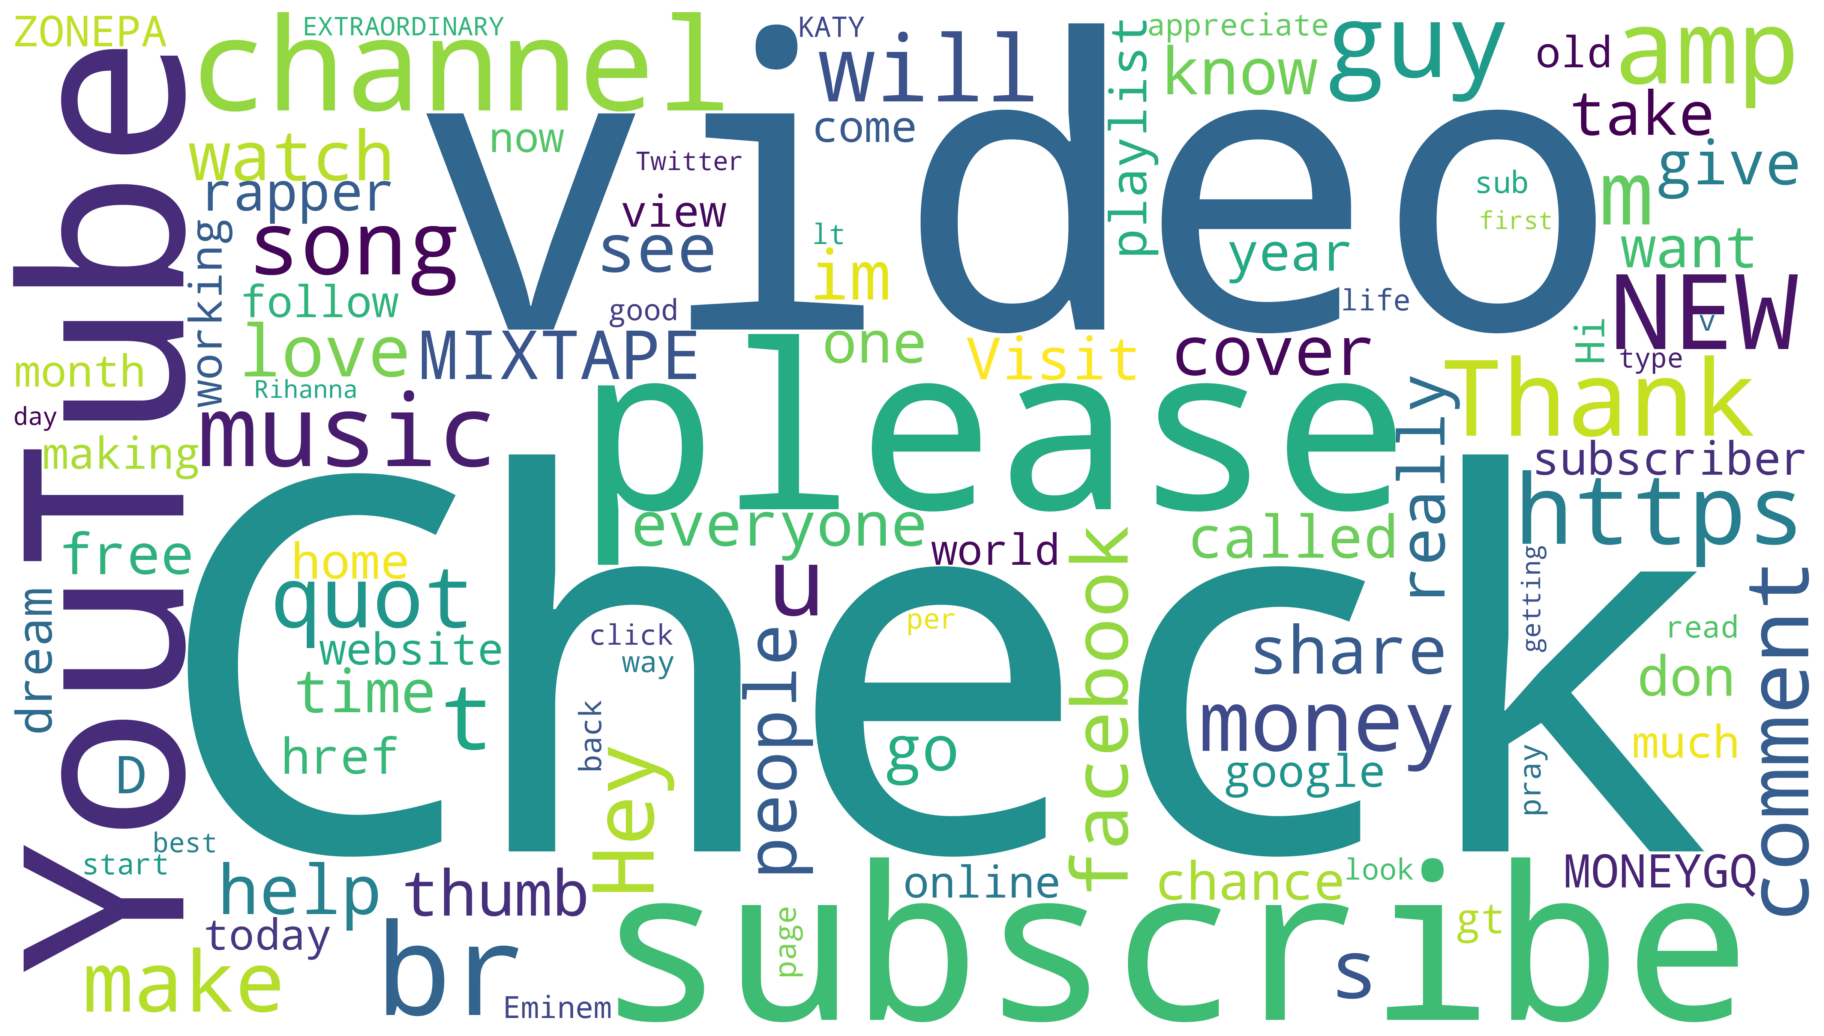

In [12]:
def wc(data, color):
    plt.figure(figsize=(15, 15), dpi=120)  # Dimensioni e DPI aumentati

    wc = WordCloud(
        background_color=color,
        stopwords=STOPWORDS,
        width=1600,              # Risoluzione orizzontale aumentata
        height=900,             # Risoluzione verticale aumentata
        scale=3,                 # Fattore di scala per maggiore nitidezza
        max_words=100,           # Numero maggiore di parole visualizzabili
        collocations=False,      # Migliora la disposizione evitando ripetizioni
        prefer_horizontal=0.9
    )

    wc.generate(' '.join(data))
    plt.imshow(wc, interpolation='bilinear')  # Interpolazione per smoothing
    plt.axis('off')
    plt.tight_layout(pad=0)      # Elimina spazi bianchi attorno all'immagine


wc(df[df["CLASS"]==1]['CONTENT'], "white")

Non spam comments word cloud

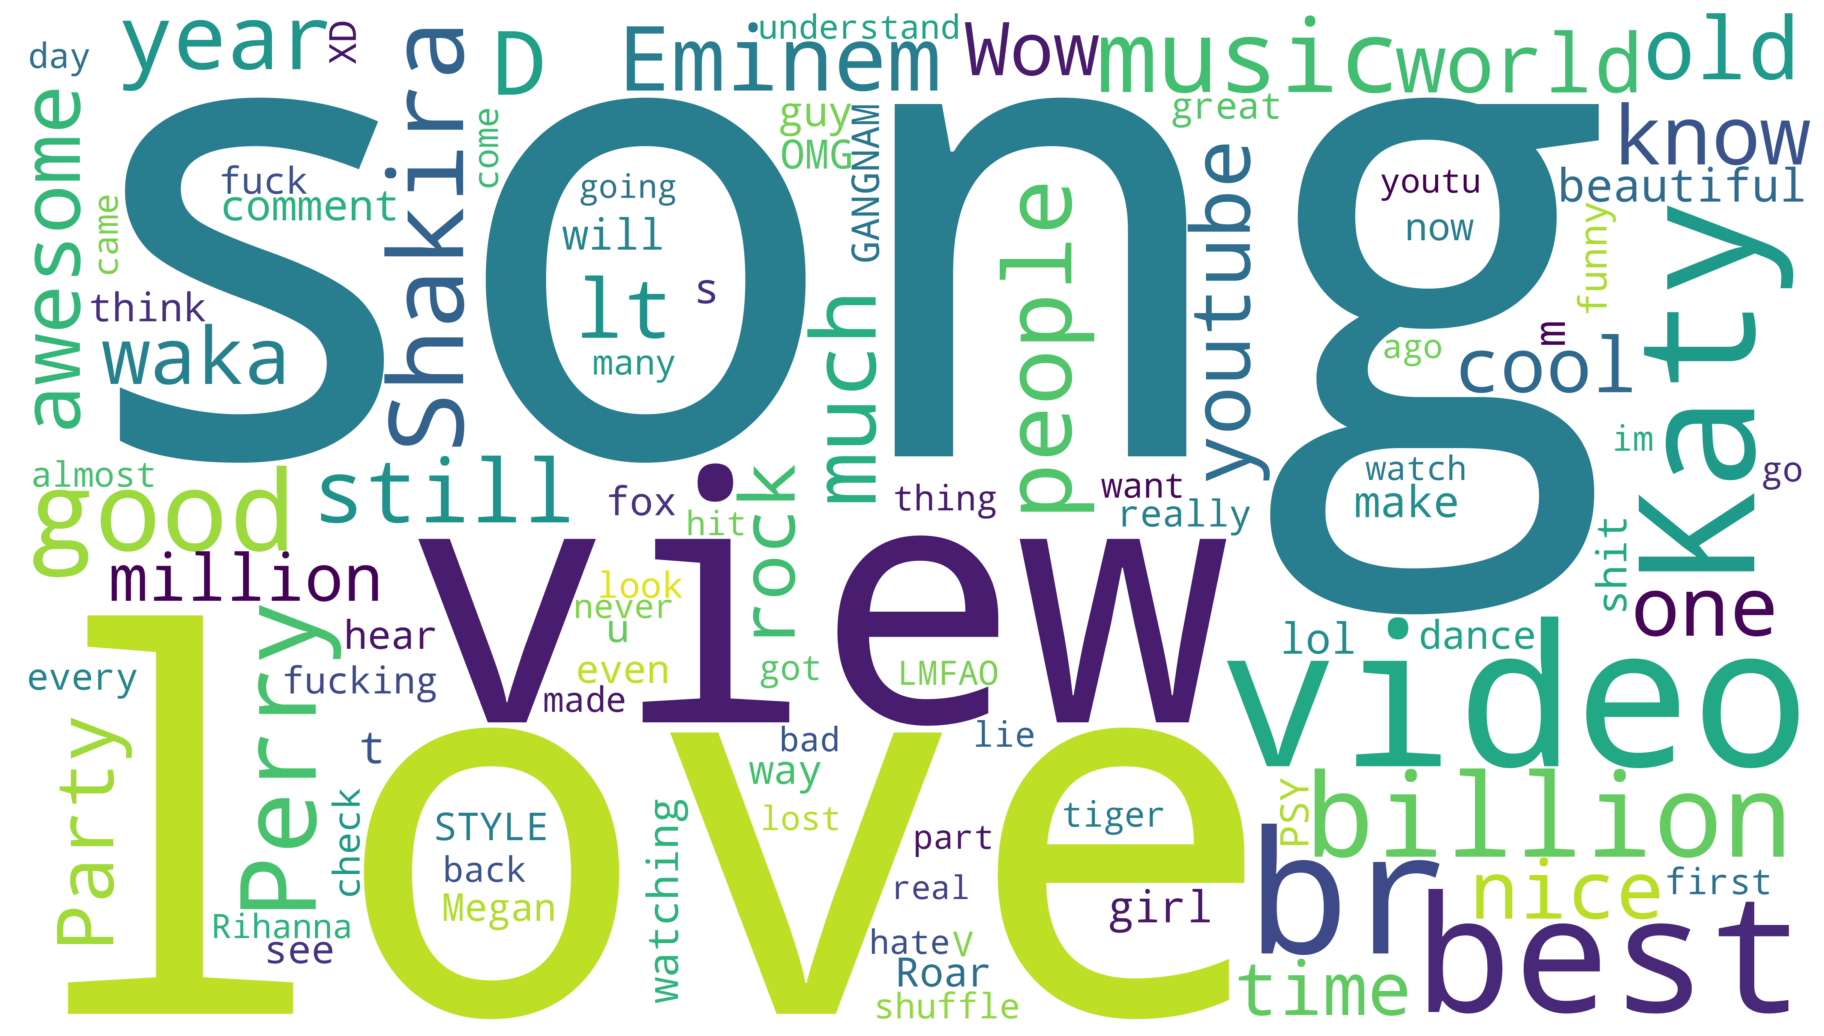

In [13]:
def wc(data, color):
    plt.figure(figsize=(15, 15), dpi=120)  # Dimensioni e DPI aumentati

    wc = WordCloud(
        background_color=color,
        stopwords=STOPWORDS,
        width=1600,              # Risoluzione orizzontale aumentata
        height=900,             # Risoluzione verticale aumentata
        scale=3,                 # Fattore di scala per maggiore nitidezza
        max_words=100,           # Numero maggiore di parole visualizzabili
        collocations=False,      # Migliora la disposizione evitando ripetizioni
        prefer_horizontal=0.9
    )

    wc.generate(' '.join(data))
    plt.imshow(wc, interpolation='bilinear')  # Interpolazione per smoothing
    plt.axis('off')
    plt.tight_layout(pad=0)      # Elimina spazi bianchi attorno all'immagine


wc(df[df["CLASS"]==0]['CONTENT'], "white")

# Neural network

## NN (dtm unsupervised)

At this point, we attempt to build a neural network to classify the comments. As before, the model development will be divided into two parts:

* One neural network will be trained on the principal components obtained from raw document-term matrix (DTM).

* The other neural network will be trained on the pcs from the optimized DTM.

We start with the non-optimized DTM. The 17 principal components (PCs) were extracted in R.
To simplify access, the dataset containing these components was uploaded to my GitHub repository, allowing for easy download and use in model development.

In [ ]:
base_url = "https://raw.githubusercontent.com/PietroParenti/yt-comments-classifier/main/"

# Nomi corretti dei file
file_test = "dtm.pc.test.csv"
file_train = "dtm.pc.train.csv"

# Creazione dei DataFrame
dtm_pc_test = pd.read_csv(base_url + file_test)
dtm_pc_train = pd.read_csv(base_url + file_train)

# Controllo rapido
dtm_pc_test.head(3), dtm_pc_train.head(3)

(        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
 0 -0.247439 -0.738391 -1.772072 -0.482443 -0.080005  0.007272 -0.450792   
 1 -0.189965 -0.455615 -1.231545 -0.269116 -0.031265 -0.173402 -0.370778   
 2 -0.247239 -0.623990 -1.117954 -0.042319 -0.180447 -0.340478 -0.865295   
 
         PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
 0  0.201214 -0.134051 -0.157457  0.259628 -0.213153  0.579333  0.077140   
 1 -0.046173  0.436536 -0.386861  0.271203 -0.159714  0.266390  0.125344   
 2 -0.757558 -1.449499 -0.867204  0.319951 -0.110039  0.590166 -0.078678   
 
        PC15      PC16      PC17  spam  
 0 -0.325509 -0.061302  0.120590     1  
 1 -0.037126  0.117238 -0.086316     1  
 2 -0.257058 -0.086914  0.176118     1  ,
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
 0 -0.221243 -0.536133 -0.969047 -0.148919 -0.111701 -0.415705 -0.552260   
 1  0.090901 -0.404136 -2.057025 -0.925664  0.604263  0.474330 -0.22559

Split Xs and y for training and test set.

In [ ]:
# Separa le feature e il target per il training set
X_train = dtm_pc_train.drop(columns=['spam'])
y_train = dtm_pc_train['spam']

# Separa le feature e il target per il test set
X_test = dtm_pc_test.drop(columns=['spam'])
y_test = dtm_pc_test['spam']

Here we create the first neural network. This neural network has:

* the input layer with 17 neurons (like the pcs)

* 1 hidden layer with 8 neurons

* 1 output neuron (because it's binary classification) with sigmoid activation (outputs a value between 0 and 1, like a probability)





Other parameters are:

* epochs=20. An epoch is one full pass through the entire training dataset. Setting epochs=20 means the model will go through the training data 20 times to try to learn better. More epochs can help the model learn better, but too many might cause overfitting.

* batch_size=32. A batch is a small group of samples the model uses to update its weights once. batch_size=32 means the model will look at 32 samples at a time, compute the error, and update the weights.

* validation_split=0.2. This reserves part of the training data to check how well the model is learning on unseen data during training. 0.2 means 20% of the training data will be used as a validation set, and the remaining 80% will actually be used to train the model. This helps monitor overfitting while training: if training accuracy goes up but validation accuracy does not, the model may be overfitting.

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5620 - loss: 0.9272 - val_accuracy: 0.0226 - val_loss: 1.2415
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5662 - loss: 0.8214 - val_accuracy: 0.0263 - val_loss: 1.0955
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5889 - loss: 0.7460 - val_accuracy: 0.0338 - val_loss: 1.0012
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5853 - loss: 0.7090 - val_accuracy: 0.0489 - val_loss: 0.9404
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6074 - loss: 0.6854 - val_accuracy: 0.0677 - val_loss: 0.9035
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6179 - loss: 0.6677 - val_accuracy: 0.0865 - val_loss: 0.8798
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6365 - loss: 0.6522 - val_accuracy: 0.1090 - val_loss: 0.8630
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6391 - loss: 0.6379 - val_accuracy: 0.1466 - val_loss: 0.8503
Ep

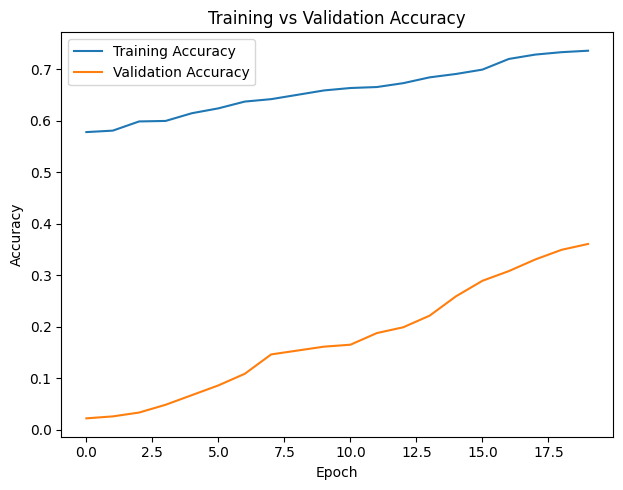

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt


seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)


model = Sequential([
    Dense(8, activation='relu', input_shape=(17,)),  # Hidden layer with 8 neurons
    Dense(1, activation='sigmoid')                    # Output layer for binary classification
])


learning_rate = 0.001  # example learning rate
optimizer = Adam(learning_rate=learning_rate)


model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


The first layer of the network has 144 parameters

((17 input neurons + 1 bias) × 8 output neurons = 144 parameters)

 The second layer has 9:

 ((8 input neurons + 1 bias) × 1 output neurons = 9 parameters)

 Total params: 144 + 9 = 153

The training accuracy improves steadily from about 56% at epoch 1 to approximately 72% at epoch 20, showing that the model is learning the training data well.

The validation accuracy starts very low around 2% and gradually increases to about 36% by the 20th epoch. While this is an improvement, the validation accuracy remains much lower than training accuracy, suggesting the model struggles to generalize well to unseen data.

The gap between training and validation accuracy suggests overfitting

The parameters previously chosen were selected arbitrarily. Now, using a for loop, we will search for the best combination of parameters. I will keep the number of parameters to test low to avoid the code taking too long to run.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import numpy as np
import random
import os


def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

# Parametri da testare
neurons_list = [4, 8]
learning_rates = [0.001, 0.01]
batch_sizes = [16, 32]
epochs_list = [10, 20]
n_repeats = 10  # Numero di ripetizioni per ciascuna combinazione

results = []

for neurons in neurons_list:
    for lr in learning_rates:
        for batch in batch_sizes:
            for epochs in epochs_list:
                acc_list = []

                for rep in range(n_repeats):
                    set_seed(42 + rep)  # Cambia leggermente il seed a ogni ripetizione

                    model = Sequential([
                        Dense(neurons, activation='relu', input_shape=(17,)),
                        Dense(1, activation='sigmoid')
                    ])

                    optimizer = Adam(learning_rate=lr)
                    model.compile(optimizer=optimizer,
                                  loss='binary_crossentropy',
                                  metrics=['accuracy'])

                    model.fit(X_train, y_train,
                              epochs=epochs,
                              batch_size=batch,
                              verbose=0,
                              validation_split=0.2)

                    y_pred = model.predict(X_test)
                    y_pred_binary = (y_pred > 0.5).astype(int)
                    acc = accuracy_score(y_test, y_pred_binary)
                    acc_list.append(acc)

                avg_acc = np.mean(acc_list)

                results.append({
                    'neurons': neurons,
                    'learning_rate': lr,
                    'batch_size': batch,
                    'epochs': epochs,
                    'test_accuracy': avg_acc
                })

                print(f"neurons={neurons}, lr={lr}, batch={batch}, epochs={epochs}, "
                      f"avg_acc={avg_acc:.4f}")

# Trova la combinazione migliore
best = max(results, key=lambda x: x['test_accuracy'])
print("\n Migliori iperparametri trovati (media su 10 ripetizioni):")
print(best)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
neurons=4, lr=0.001, batch=16, epochs=10, avg_acc=0.5778


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=4, lr=0.001, batch=16, epochs=20, avg_acc=0.6472


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=4, lr=0.001, batch=32, epochs=10, avg_acc=0.5621


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
neurons=4, lr=0.001, batch=32, epochs=20, avg_acc=0.6044


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
neurons=4, lr=0.01, batch=16, epochs=10, avg_acc=0.8191


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=4, lr=0.01, batch=16, epochs=20, avg_acc=0.8252


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=4, lr=0.01, batch=32, epochs=10, avg_acc=0.8087


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=4, lr=0.01, batch=32, epochs=20, avg_acc=0.8257


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.001, batch=16, epochs=10, avg_acc=0.6133


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.001, batch=16, epochs=20, avg_acc=0.7262


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.001, batch=32, epochs=10, avg_acc=0.5862


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.001, batch=32, epochs=20, avg_acc=0.6631


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.01, batch=16, epochs=10, avg_acc=0.8255


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.01, batch=16, epochs=20, avg_acc=0.8309


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.01, batch=32, epochs=10, avg_acc=0.8171


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.01, batch=32, epochs=20, avg_acc=0.8329

📈 Migliori iperparametri trovati (media su 10 ripetizioni):
{'neurons': 8, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 20, 'test_accuracy': np.float64(0.8328671328671329)}


Let's retrain the network with the best selected parameters.

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5654 - loss: 0.7914 - val_accuracy: 0.2782 - val_loss: 0.7959
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6505 - loss: 0.5878 - val_accuracy: 0.3158 - val_loss: 0.8036
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7246 - loss: 0.5456 - val_accuracy: 0.6767 - val_loss: 0.7556
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8088 - loss: 0.5147 - val_accuracy: 0.7481 - val_loss: 0.7108
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8380 - loss: 0.4919 - val_accuracy: 0.7782 - val_loss: 0.6932
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8422 - loss: 0.4708 - val_accuracy: 0.8045 - val_loss: 0.6729
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8422 - loss: 0.4556 - val_accuracy: 0.8083 - val_loss: 0.6654
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8501 - loss: 0.4426 - val_accuracy: 0.8045 - val_loss: 0.6630
Ep

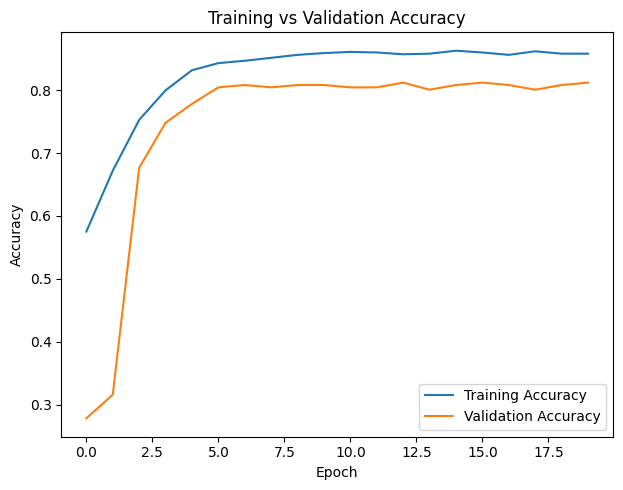

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt


seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)


model = Sequential([
    Dense(8, activation='relu', input_shape=(17,)),  # Hidden layer with 8 neurons
    Dense(1, activation='sigmoid')                    # Output layer for binary classification
])


learning_rate = 0.01  # example learning rate
optimizer = Adam(learning_rate=learning_rate)


model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


The model shows a clear improvement in both training and validation accuracy over the 20 epochs. Starting from an initial training accuracy around 56.5%, it steadily increases to about 86.1% by the last epoch. Similarly, validation accuracy improves significantly from roughly 27.8% to around 81.2%, indicating that the model is learning and generalizing well without overfitting.

I graphically draw the neural network architecture.

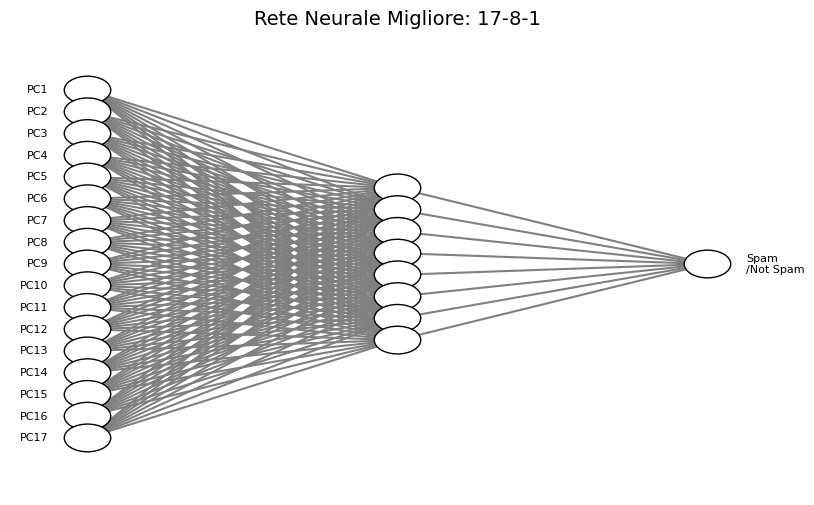

In [ ]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes, input_labels=None):
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(n_layers - 1)

    # Nodes
    for i, n_nodes in enumerate(layer_sizes):
        layer_top = v_spacing * (n_nodes - 1) / 2. + (top + bottom) / 2.
        for j in range(n_nodes):
            circle = plt.Circle((i * h_spacing + left, layer_top - j * v_spacing), 0.03,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            # Label input and output nodes
            if i == 0 and input_labels is not None:
                ax.text(i * h_spacing + left - 0.05, layer_top - j * v_spacing,
                        input_labels[j], ha='right', va='center', fontsize=8)
            elif i == n_layers - 1:
                ax.text(i * h_spacing + left + 0.05, layer_top - j * v_spacing,
                        'Spam\n/Not Spam', ha='left', va='center', fontsize=8)

    # Connections
    for i, (n0, n1) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top0 = v_spacing * (n0 - 1) / 2. + (top + bottom) / 2.
        layer_top1 = v_spacing * (n1 - 1) / 2. + (top + bottom) / 2.
        for j in range(n0):
            for k in range(n1):
                line = plt.Line2D([i * h_spacing + left, (i + 1) * h_spacing + left],
                                  [layer_top0 - j * v_spacing, layer_top1 - k * v_spacing],
                                  c='gray')
                ax.add_artist(line)

# Etichette input: PC1 ... PC17
input_labels = [f'PC{i+1}' for i in range(17)]

# Parametri della rete: 17 input, 8 hidden, 1 output
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
draw_neural_net(ax, 0.1, 0.9, 0.1, 0.9, [17, 8, 1], input_labels=input_labels)
plt.title('Rete Neurale Migliore: 17-8-1', fontsize=14)
plt.show()


I evaluate the performance of the newly designed neural network on the test data to conclude. This performance can then be compared with the performances of other models developed during the study.

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test Accuracy: {test_accuracy:.4f}")

18/18 - 0s - 6ms/step - accuracy: 0.8182 - loss: 0.4606
Test Accuracy: 0.8182


## NN (dtm supervised)

As mentioned earlier, we perform the same construction of a neural network but on the PCs derived from the optimized DTM.

In [ ]:
base_url = "https://raw.githubusercontent.com/PietroParenti/yt-comments-classifier/main/"

# Nomi corretti dei file
file_test = "dtm2.pc.test.csv"
file_train = "dtm2.pc.train.csv"

# Creazione dei DataFrame
dtm_pc_test = pd.read_csv(base_url + file_test)
dtm_pc_train = pd.read_csv(base_url + file_train)

# Controllo rapido
dtm_pc_test.head(3), dtm_pc_train.head(3)

(        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
 0 -0.340607 -0.803296  0.716919 -0.493472 -0.186633  0.375930 -0.213900   
 1 -0.248179 -0.590320  0.604162 -0.364113 -0.267738  0.072890 -0.253261   
 2 -0.366400 -0.614706  0.324138  0.068927 -0.032129  1.110085  1.260685   
 
         PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
 0 -0.206759 -0.178338 -0.198980  0.414259  0.062754  0.273448 -0.212424   
 1 -0.145547  0.182517 -0.353931  0.156918  0.139085  0.186989 -0.180793   
 2 -0.855357 -0.580245 -0.609753  0.466971  0.026331  0.129871 -0.360015   
 
        PC15      PC16      PC17  spam  
 0  0.294809  0.268350 -0.336943     1  
 1  0.190308  0.252547  0.019855     1  
 2  0.391152  0.201752 -0.238940     1  ,
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
 0 -0.347516 -0.650280  0.451825 -0.095792 -0.566232  0.252209 -0.560554   
 1  0.169639 -0.268297  0.048687 -0.920362 -0.121802 -0.045380  0.28164

Split Xs and y for training and test set.

In [ ]:
# Separa le feature e il target per il training set
X_train = dtm_pc_train.drop(columns=['spam'])
y_train = dtm_pc_train['spam']

# Separa le feature e il target per il test set
X_test = dtm_pc_test.drop(columns=['spam'])
y_test = dtm_pc_test['spam']

Here we create the first neural network. This neural network has:

* 17 input neurons

* 1 hidden layer with 8 neurons

* 1 output neuron

* epochs=20

* batch_size=32

* validation split=0.2

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5973 - loss: 0.6318 - val_accuracy: 0.2368 - val_loss: 0.8082
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6168 - loss: 0.6205 - val_accuracy: 0.2556 - val_loss: 0.8084
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6342 - loss: 0.6121 - val_accuracy: 0.2782 - val_loss: 0.8062
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6479 - loss: 0.6047 - val_accuracy: 0.3383 - val_loss: 0.8024
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6636 - loss: 0.5980 - val_accuracy: 0.3985 - val_loss: 0.7989
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6984 - loss: 0.5921 - val_accuracy: 0.4962 - val_loss: 0.7958
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7179 - loss: 0.5876 - val_accuracy: 0.5301 - val_loss: 0.7926
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7289 - loss: 0.5839 - val_accuracy: 0.5564 - val_loss: 0.7895
Epo

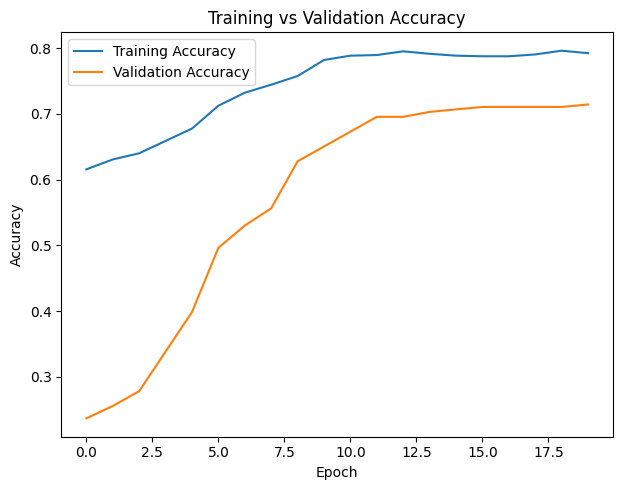

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt


seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)


model = Sequential([
    Dense(8, activation='relu', input_shape=(17,)),  # Hidden layer with 8 neurons
    Dense(1, activation='sigmoid')                    # Output layer for binary classification
])


learning_rate = 0.001  # example learning rate
optimizer = Adam(learning_rate=learning_rate)


model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


Total params: 144 + 9 = 153

The accuracy steadily improves from around 60% in the first epochs to over 78% in the later epochs, indicating the model is learning well on the training data.

Validation accuracy: Validation accuracy starts very low (around 23%) but steadily increases to stabilize around 71-71.5%. This shows the model’s generalization ability is improving, although it starts from a low baseline.

The parameters previously chosen were selected arbitrarily. Now, using a for loop, we will search for the best combination of parameters. I will keep the number of parameters to test low to avoid the code taking too long to run.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import numpy as np
import random
import os


def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

# Parametri da testare
neurons_list = [4, 8]
learning_rates = [0.001, 0.01]
batch_sizes = [16, 32]
epochs_list = [10, 20]
n_repeats = 10  # Numero di ripetizioni per ciascuna combinazione

results = []

for neurons in neurons_list:
    for lr in learning_rates:
        for batch in batch_sizes:
            for epochs in epochs_list:
                acc_list = []

                for rep in range(n_repeats):
                    set_seed(42 + rep)  # Cambia leggermente il seed a ogni ripetizione

                    model = Sequential([
                        Dense(neurons, activation='relu', input_shape=(17,)),
                        Dense(1, activation='sigmoid')
                    ])

                    optimizer = Adam(learning_rate=lr)
                    model.compile(optimizer=optimizer,
                                  loss='binary_crossentropy',
                                  metrics=['accuracy'])

                    model.fit(X_train, y_train,
                              epochs=epochs,
                              batch_size=batch,
                              verbose=0,
                              validation_split=0.2)

                    y_pred = model.predict(X_test)
                    y_pred_binary = (y_pred > 0.5).astype(int)
                    acc = accuracy_score(y_test, y_pred_binary)
                    acc_list.append(acc)

                avg_acc = np.mean(acc_list)

                results.append({
                    'neurons': neurons,
                    'learning_rate': lr,
                    'batch_size': batch,
                    'epochs': epochs,
                    'test_accuracy': avg_acc
                })

                print(f"neurons={neurons}, lr={lr}, batch={batch}, epochs={epochs}, "
                      f"avg_acc={avg_acc:.4f}")

# Trova la combinazione migliore
best = max(results, key=lambda x: x['test_accuracy'])
print("\n Migliori iperparametri trovati (media su 10 ripetizioni):")
print(best)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
neurons=4, lr=0.001, batch=16, epochs=10, avg_acc=0.5682


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=4, lr=0.001, batch=16, epochs=20, avg_acc=0.6544


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
neurons=4, lr=0.001, batch=32, epochs=10, avg_acc=0.5273


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=4, lr=0.001, batch=32, epochs=20, avg_acc=0.5997


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=4, lr=0.01, batch=16, epochs=10, avg_acc=0.7850


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=4, lr=0.01, batch=16, epochs=20, avg_acc=0.8016


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
neurons=4, lr=0.01, batch=32, epochs=10, avg_acc=0.7795


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=4, lr=0.01, batch=32, epochs=20, avg_acc=0.7983


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.001, batch=16, epochs=10, avg_acc=0.6851


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.001, batch=16, epochs=20, avg_acc=0.7601


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.001, batch=32, epochs=10, avg_acc=0.6530


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.001, batch=32, epochs=20, avg_acc=0.7159


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.01, batch=16, epochs=10, avg_acc=0.8040


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.01, batch=16, epochs=20, avg_acc=0.8185


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
neurons=8, lr=0.01, batch=32, epochs=10, avg_acc=0.7970


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
neurons=8, lr=0.01, batch=32, epochs=20, avg_acc=0.8121

 Migliori iperparametri trovati (media su 10 ripetizioni):
{'neurons': 8, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 20, 'test_accuracy': np.float64(0.8185314685314686)}


Let's retrain the network with the best selected parameters.

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6252 - loss: 0.6104 - val_accuracy: 0.7293 - val_loss: 0.7390
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7539 - loss: 0.5627 - val_accuracy: 0.7368 - val_loss: 0.7731
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7636 - loss: 0.5492 - val_accuracy: 0.7180 - val_loss: 0.8187
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7641 - loss: 0.5417 - val_accuracy: 0.6391 - val_loss: 0.8362
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7669 - loss: 0.5354 - val_accuracy: 0.6617 - val_loss: 0.8324
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7843 - loss: 0.5319 - val_accuracy: 0.6654 - val_loss: 0.8293
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7866 - loss: 0.5278 - val_accuracy: 0.6729 - val_loss: 0.8229
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8008 - loss: 0.5215 - val_accuracy: 0.6917 - val_loss: 0.8195
Epo

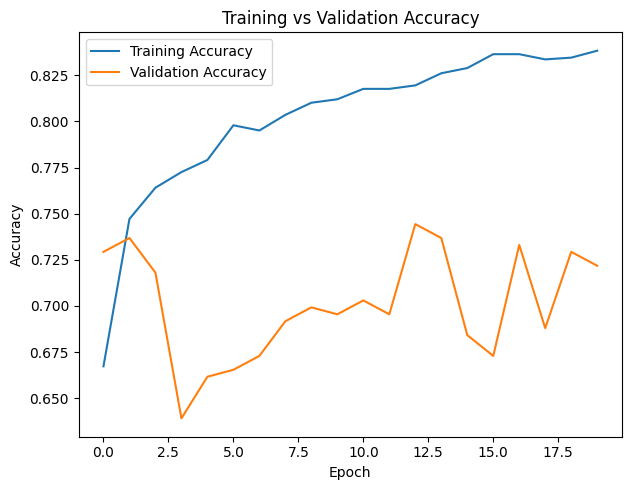

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt


seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)


model = Sequential([
    Dense(8, activation='relu', input_shape=(17,)),  # Hidden layer with 8 neurons
    Dense(1, activation='sigmoid')                    # Output layer for binary classification
])


learning_rate = 0.01  # example learning rate
optimizer = Adam(learning_rate=learning_rate)


model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)


plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


During training, the neural network shows a steady improvement in its ability to correctly classify the training data, increasing from around 62% accuracy initially to over 84% in the later epochs. On the validation set, accuracy starts at a fairly good level, about 73%, and remains generally stable around 70-74%, indicating a good capacity for generalization.

I graphically draw the neural network architecture.

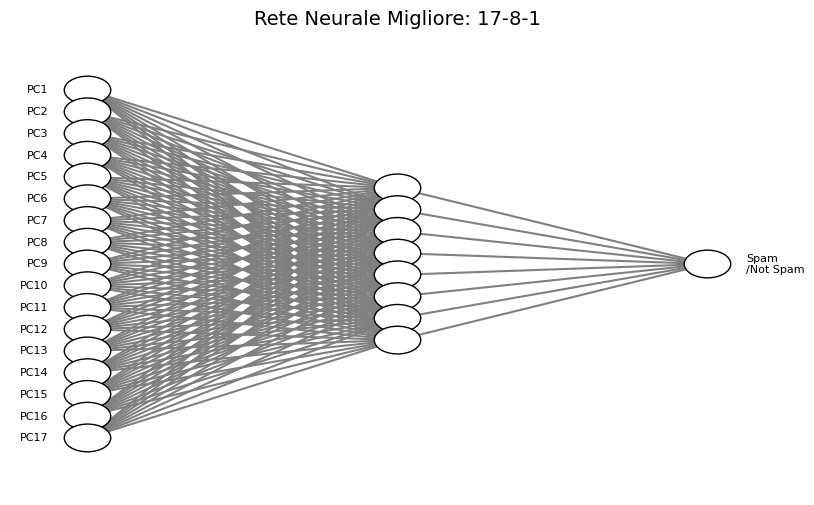

In [ ]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes, input_labels=None):
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(n_layers - 1)

    # Nodes
    for i, n_nodes in enumerate(layer_sizes):
        layer_top = v_spacing * (n_nodes - 1) / 2. + (top + bottom) / 2.
        for j in range(n_nodes):
            circle = plt.Circle((i * h_spacing + left, layer_top - j * v_spacing), 0.03,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            # Label input and output nodes
            if i == 0 and input_labels is not None:
                ax.text(i * h_spacing + left - 0.05, layer_top - j * v_spacing,
                        input_labels[j], ha='right', va='center', fontsize=8)
            elif i == n_layers - 1:
                ax.text(i * h_spacing + left + 0.05, layer_top - j * v_spacing,
                        'Spam\n/Not Spam', ha='left', va='center', fontsize=8)

    # Connections
    for i, (n0, n1) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top0 = v_spacing * (n0 - 1) / 2. + (top + bottom) / 2.
        layer_top1 = v_spacing * (n1 - 1) / 2. + (top + bottom) / 2.
        for j in range(n0):
            for k in range(n1):
                line = plt.Line2D([i * h_spacing + left, (i + 1) * h_spacing + left],
                                  [layer_top0 - j * v_spacing, layer_top1 - k * v_spacing],
                                  c='gray')
                ax.add_artist(line)

# Etichette input: PC1 ... PC17
input_labels = [f'PC{i+1}' for i in range(17)]

# Parametri della rete: 17 input, 8 hidden, 1 output
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
draw_neural_net(ax, 0.1, 0.9, 0.1, 0.9, [17, 8, 1], input_labels=input_labels)
plt.title('Rete Neurale Migliore: 17-8-1', fontsize=14)
plt.show()


I evaluate the performance of the newly designed neural network on the test data to conclude. This performance can then be compared with the performances of other models developed during the study.

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test Accuracy: {test_accuracy:.4f}")

18/18 - 0s - 4ms/step - accuracy: 0.8094 - loss: 0.5262
Test Accuracy: 0.8094


# Optimal pipeline

The original datasets are reconstructed.

In [ ]:
base_url = "https://raw.githubusercontent.com/PietroParenti/yt-comments-classifier/main/"

file_names = [
    "Youtube01-Psy.csv",
    "Youtube02-KatyPerry.csv",
    "Youtube03-LMFAO.csv",
    "Youtube04-Eminem.csv",
    "Youtube05-Shakira.csv"
]

urls = [base_url + fname for fname in file_names]

dataframes = [pd.read_csv(url) for url in urls]

df_original = pd.concat(dataframes, ignore_index=True)

df_original.loc[df_original.index<5,:]

df = df_original

In [ ]:
df_unbalanced=df

random.seed(1)

def underSample2Min(df, labelName):
    vc = df.loc[:,labelName].value_counts()
    lab2freq = dict(zip(vc.index.tolist(), vc.values.tolist()))
    minfreq = min(lab2freq.values())
    idxSample=[]
    for selectedLabel, actualFreq in lab2freq.items():
        selIndexes=df.loc[df.loc[:,labelName]==selectedLabel, :].sample(n=minfreq).index.tolist()
        idxSample+=selIndexes
    idxSample.sort()

    df2 = df.loc[idxSample, :]
    df2 = df2.reset_index()
    return df2

df = underSample2Min(df_unbalanced, 'CLASS')

print("="*50)
print("Observation count per class:")
print(df['CLASS'].value_counts())

Observation count per class:
CLASS
1    951
0    951
Name: count, dtype: int64


In [ ]:
xAll = df.loc[:,'CONTENT']
yAll = df.loc[:,'CLASS']
print('type(xAll)', type(xAll), 'xAll.shape', xAll.shape)
print('type(yAll)', type(yAll), 'xAll.shape', yAll.shape)
print()

xTrainVec, xTestVec, yTrain, yTest = train_test_split(
    xAll, yAll,
    test_size=0.30,
    random_state=0,
    stratify=yAll
)

varDi = {'xAll':xAll, 'yAll':yAll, 'xTrainVec':xTrainVec, 'xTestVec':xTestVec, 'yTrain':yTrain, 'yTest':yTest}
for varName, var in varDi.items(): # return a list of key-value pairs
  print(varName, var.shape)

xTrain = list(xTrainVec)
xTest = list(xTestVec)

type(xAll) <class 'pandas.core.series.Series'> xAll.shape (1902,)
type(yAll) <class 'pandas.core.series.Series'> xAll.shape (1902,)

xAll (1902,)
yAll (1902,)
xTrainVec (1331,)
xTestVec (571,)
yTrain (1331,)
yTest (571,)


This code builds and applies a machine learning pipeline in scikit-learn to classify texts using Logistic Regression.

In the first part it transforms raw text into a document-term matrix using CountVectorizer. Then applies logistic regression to classify the output of the vectorizer.

In the second part of the code the pipeline sets the following parameters:

* classifier__C: regularization strength for Logistic Regression

* vectorizer__stop_words: removes English stopwords

* vectorizer__ngram_range: uses only unigrams (single words)

In [ ]:
cp = Pipeline(
    [
      ('vectorizer', CountVectorizer()),
      ('classifier', LogisticRegression() ),
    ]
)

clsfParams = {
   'classifier__C': 0.001,
   'vectorizer__stop_words':'english',
   'vectorizer__ngram_range': (1,1),
}


cp.set_params(**clsfParams)
cp.fit(xTrain, yTrain)

yPred=cp.predict(xTest)

print("="*50)
print('Accuracy')
print(accuracy_score(yTest,yPred))
print("="*50)

Accuracy
0.882661996497373


An excellent result was already achieved with this first pipeline. Now let's try to improve it.

Optimising text pipeline components

In [ ]:
class BaseWrapper(BaseEstimator, TransformerMixin):
    """class wrapping a sentence processing function so that it can be used in a sklearn.pipeline.Pipeline"""

    def fit(self, x, y=None): #This method is usually overridden in children classes
        """ This method actually does nothing.
        It will be overridden by the child classes.
        In its children implementations this method will perform all the
        setup activities required before calling either the method transform()
        or the method predict().
        E.g., a machine learning classifier is trained calling the fit() method,
        once trained it can be used to classify new elements by calling the method predict()
        """
        return self

    def manageSentence(self, sentence): #This method is usually overridden in children classes
        """Called by transform(). The sentence is expected to be a either a string or a list of words,
        this method can return either a string or a list of words"""
        return sentence

    def transform(self, listOfSentences):
        """ sentenceList: list of sentences.
        Every sentence can be either a string or a list of words
        Return a list of lists. Each sentence is preprocessed using the manageSentence() method.
        Each child class can override the manageSentence() method to implement a specific preprocessing behavior.
        The list of preprocessed documents is returned."""
        toReturn = []
        for sentence in listOfSentences:
            processedSentence = self.manageSentence(sentence)
            toReturn.append(processedSentence)
        return toReturn

class HTMLAccentsReplacer(BaseWrapper):
    def manageSentence(self, sentence):
        """Replace html representations of special letters with the corresponding unicode character.
        E.g.  &agrave with à.
        Args:
           * s(string): the string where the html codes should be replaced  """
        assert type(sentence)==type('') or type(sentence)==type(u''), "HTMLAccentsReplacer Assertion Error"
        replacemap={'&Ecirc;': 'Ê', '&raquo;': '»', '&eth;': 'ð', '&divide;': '÷', '&atilde;': 'ã', '&Aelig;':
                    'Æ', '&frac34;': '¾', '&nbsp;': ' ', '&Aumbl;': 'Ä', '&Ouml;': 'Ö', '&Egrave;': 'È', '&Icirc;': 'Î',
                    '&deg;': '°', '&ocirc;': 'ô', '&Ugrave;': 'Ù', '&ndash;': '–', '&gt;': '>', '&Thorn;': 'Þ',
                    '&aring;': 'å', '&frac12;': '½', '&frac14;': '¼', '&Aacute;': 'Á', '&szlig;': 'ß', '&trade;': '™',
                    '&igrave;': 'ì', '&aelig;': 'æ', '&times;': '×', '&egrave;': 'è', '&Atilde;': 'Ã', '&Igrave;': 'Ì',
                    '&Eth;': 'Ð', '&ucirc;': 'û', '&lsquo;': '‘', '&agrave;': 'à', '&thorn;': 'þ', '&Ucirc;': 'Û',
                    '&amp;': '&', '&uuml;': 'ü', '&yuml;': '', '&ecirc;': 'ê', '&laquo;': '«', '&infin;': '∞',
                    '&Ograve;': 'Ò', '&oslash;': 'ø', '&yacute;': 'ý', '&plusmn;': '±', '&icirc;': 'î', '&auml;': 'ä',
                    '&ouml;': 'ö', '&Ccedil;': 'Ç', '&euml;': 'ë', '&lt;': '<', '&eacute;': 'é', '&ntilde;': 'ñ',
                    '&pound;': '£', '&Iuml;': 'Ï', '&Eacute;': 'É', '&Ntilde;': 'Ñ', '&rsquo;': '’', '&euro;': '€',
                    '&rdquo;': '”', '&Acirc;': 'Â', '&ccedil;': 'ç', '&Iacute;': 'Í', '&quot;': '"', '&Aring;': 'Å',
                    '&Oslash;': 'Ø', '&Otilde;': 'Õ', '&Uacute;': 'Ú', '&reg;': '®', '&Yacute;': 'Ý', '&iuml;': 'ï',
                    '&ugrave;': 'ù', '&alpha;': 'α', '&copy;': '©', '&ldquo;': '“', '&oacute;': 'ó', '&Euml;': 'Ë',
                    '&uacute;': 'ú', '&ograve;': 'ò', '&acirc;': 'â', '&aacute;': 'á', '&Agrave;': 'À', '&Oacute;': 'Ó',
                    '&Uuml;': 'Ü', '&iacute;': 'í', '&cent;': '¢', '&Ocirc;': 'Ô', '&mdash;': '—', '&otilde;': 'õ',
                    '&beta;': 'β'
        }
        '''
        replacemap={u'&Ecirc;': u'\xca', u'&raquo;': u'\xbb', u'&eth;': u'\xf0', u'&divide;': u'\xf7',
                    u'&atilde;': u'\xe3', u'&Aelig;': u'\xc6', u'&frac34;': u'\xbe', u'&nbsp;': u' ',
                    u'&Aumbl;': u'\xc4', u'&Ouml;': u'\xd6', u'&Egrave;': u'\xc8', u'&Icirc;': u'\xce',
                    u'&deg;': u'\xb0', u'&ocirc;': u'\xf4', u'&Ugrave;': u'\xd9', u'&ndash;': u'\u2013',
                    u'&gt;': u'>', u'&Thorn;': u'\xde', u'&aring;': u'\xe5', u'&frac12;': u'\xbd',
                    u'&frac14;': u'\xbc', u'&Aacute;': u'\xc1', u'&szlig;': u'\xdf', u'&trade;': u'\u2122',
                    u'&igrave;': u'\xec', u'&aelig;': u'\xe6', u'&times;': u'\xd7', u'&egrave;': u'\xe8',
                    u'&Atilde;': u'\xc3', u'&Igrave;': u'\xcc', u'&Eth;': u'\xd0', u'&ucirc;': u'\xfb',
                    u'&lsquo;': u'\u2018', u'&agrave;': u'\xe0', u'&thorn;': u'\xfe', u'&Ucirc;': u'\xdb',
                    u'&amp;': u'&', u'&uuml;': u'\xfc', u'&yuml;': u'', u'&ecirc;': u'\xea', u'&laquo;': u'\xab',
                    u'&infin;': u'\u221e', u'&Ograve;': u'\xd2', u'&oslash;': u'\xf8', u'&yacute;': u'\xfd',
                    u'&plusmn;': u'\xb1', u'&icirc;': u'\xee', u'&auml;': u'\xe4', u'&ouml;': u'\xf6',
                    u'&Ccedil;': u'\xc7', u'&euml;': u'\xeb', u'&lt;': u'<', u'&eacute;': u'\xe9',
                    u'&ntilde;': u'\xf1', u'&pound;': u'\xa3', u'&Iuml;': u'\xcf', u'&Eacute;': u'\xc9',
                    u'&Ntilde;': u'\xd1', u'&rsquo;': u'\u2019', u'&euro;': u'\u20ac', u'&rdquo;': u'\u201d',
                    u'&Acirc;': u'\xc2', u'&ccedil;': u'\xe7', u'&Iacute;': u'\xcd', u'&quot;': u'"',
                    u'&Aring;': u'\xc5', u'&Oslash;': u'\xd8', u'&Otilde;': u'\xd5', u'&Uacute;': u'\xda',
                    u'&reg;': u'\xae', u'&Yacute;': u'\xdd', u'&iuml;': u'\xef', u'&ugrave;': u'\xf9',
                    u'&alpha;': u'\u03b1', u'&copy;': u'\xa9', u'&ldquo;': u'\u201c', u'&oacute;': u'\xf3',
                    u'&Euml;': u'\xcb', u'&uacute;': u'\xfa', u'&ograve;': u'\xf2', u'&acirc;': u'\xe2',
                    u'&aacute;': u'\xe1', u'&Agrave;': u'\xc0', u'&Oacute;': u'\xd3', u'&Uuml;': u'\xdc',
                    u'&iacute;': u'\xed', u'&cent;': u'\xa2', u'&Ocirc;': u'\xd4', u'&mdash;': u'\u2014',
                    u'&otilde;': u'\xf5', u'&beta;': u'\u03b2'}
        '''
        for before in replacemap:
            after=replacemap[before] # getting the string to be replaced
            sentence=sentence.replace(before, after)
        return sentence

'''
# Required in python2, no more necessary in python3
class Str2Unicode(BaseWrapper):
    def manageSentence(self, sentence):
        """Converts raw strings to unicode, to better manage accented letters, money symbols (e.g., pounds)"""
        #print(type(sentence), sentence) # ****** cancellami
        # if the parameter is not the right type, the execution is interrupted
        assert type(sentence)==type('') or type(sentence)==type(u''), "Str2Unicode Assertion Error"
        if type(sentence)==type(u''): # Now it should work also with python3
            return sentence
        elif type(sentence)==type(''):
            return sentence.decode('utf-8', errors='strict')  # interpret all raw strings into unicode
        else:
            return sentence
'''

class Tokenizer(BaseWrapper):
    def manageSentence(self, sentence):
        """This method turn a single document (i.e., a string) into a list of single words (i.e., tokens).
        The parameter "sentence" is expected to be a string, this method returns a list of strings whereas each string
        is a tokenized word. This method replaces all the punctuation with spaces.
        Two or more consecuitve spaces are reduced to a single space.
        Then the strin is splitted in substring using the spaces as split markers"""

        if sentence==None:
            return[]
        # if the parameter is not the right type, the execution is interrupted
        assert type(sentence)==type('') or type(sentence)==type(u''), "Tokenizer Assertion Error"
        punteggiatura=u'!{}[]?"",;.:-<>|/\\*=+-_% \n\t\r()'+u"'" +u'\u2019'+u'\u2018' #\r and \n can be used as "new line"
        # Unicode Character 'RIGHT SINGLE QUOTATION MARK' (U+2019)
        #
        for l in punteggiatura:
           #print(s)
           sentence=sentence.replace(l,u" ") #replacing all punctuation characters with spaces

        # loop untill all double spaces are removed
        while sentence.find(u"  ")!=-1:
            sentence=sentence.replace(u"  ",u" ")  #replacing double spaces with a single one
        return sentence.split(u' ')   #e.g., "a b c d".split(' ')  returns ['a','b','c','d']

class LowerCaseReducer(BaseWrapper):
    def manageSentence(self, sentence):
        """sentence is expected to be a list of words (each item is a string),
        this method returns a list of strings whereas each string is the lower case version of the original word"""
        # preliminary check over the input data type
        assert type(sentence)==type([]), "LowerCaseReducer, Assertion Error"
        # The next line uses a python trick called List Comprehensions.
        return [w.lower() for w in sentence]
        # builds a new list, where each word of the original list is turned into a lower case string


class EnglishStopWordsRemover(BaseWrapper):
    def getStopWords(self):
        """This method returns a list of English stop words. Stop words can be added to the list"""
        return [u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves',
                u'you', u'your', u'yours', u'yourself', u'yourselves',
                u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself',
                u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves',
                u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those',
                u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being',
                u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing',
                u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while',
                u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through',
                u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out',
                u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when',
                u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other',
                u'some', u'such', u'no', u'nor', u'not', u'only', u'own', u'same', u'so', u'than', u'too', u'very',
                u's', u't', u'can', u'will', u'just', u'don', u'should', u'now', u'd', u'll', u'm', u'o', u're',
                u've', u'y', u'ain', u'aren', u'couldn', u'didn', u'doesn', u'hadn', u'hasn', u'haven', u'isn',
                u'ma', u'mightn', u'mustn', u'needn', u'shan', u'shouldn', u'wasn', u'weren', u'won', u'wouldn']

    def manageSentence(self, sentence):
        """sentence is expected to be a list of words (a list where each item is a string containing a single word),
        this method returns the input list where the stop words are removed """
        assert type(sentence)==type([]) , "EnglishStopWordsRemover, Assertion Error"
        stopWords = self.getStopWords()
        return [w for w in sentence if w not in stopWords]

class EnglishStemmer(BaseWrapper):
    def __init__(self):
        """Load the NLTK English stemmer. A stemmer is an algorithm that recues a word to its base form
        e.g., "books" is reduced to "book", 'children' is reduced to 'child'. """
        self.st = nltk.stem.SnowballStemmer("english") # loading the NLTK stemmer
    def  manageSentence(self, sentence):
        """sentence is expected to be a list of words (a list where each item is a string containing a single word),
        this method returns a list of stemmed words"""
        assert type(sentence)==type([]), "EnglishStemmer, Assertion Error"
        return [self.st.stem(w) for w in sentence]


class RemoveNumbers(BaseWrapper):
    def manageSentence(self, sentence):
        """Sentence is expected to be a list of words (a list where each item is a string containing a single word),
        this method returns the input list where the numbers are removed. """
        assert type(sentence)==type([]), "RemoveNumbers, Assertion Error"
        return [w for w in sentence if w.isdigit()==False]

class RemoveEmptyWords(BaseWrapper):
    def manageSentence(self, sentence):
        """Sentence is expected to be a list of words (a list where each item is a string containing a single word),
        this method returns the input list where the empty words are removed """
        assert type(sentence)==type([]), "RemoveEmptyWords, Assertion Error"
        return [w for w in sentence if not (w==u'' or w=='')]

class Bag2Text(BaseWrapper):
    def manageSentence(self, sentence):
        """sentence is expected to be a list of words (a list where each item is a string containing a single word),
        this method returns a single string obtained joining the words and separing them using the space"""
        assert type(sentence)==type([]), "Bag2Text, Assertion Error"
        # Next line builds a string by joining with spaces all the elements of sentence
        return u' '.join(sentence)

def unityFunction(x):
  """This function returns the same object received as input.
  For advanced pythonists: equivalent to lambda x:x """
  return x

In [ ]:
cp = Pipeline([
   #('Str2Unicode', Str2Unicode()), no more required in Python3
   ('HTMLAccentsReplacer', HTMLAccentsReplacer() ),
   ('Tokenizer', Tokenizer() ),
   ('LowerCaseReducer', LowerCaseReducer() ),
   ('StopWordsRemover', EnglishStopWordsRemover() ),
   ('Stemmer', EnglishStemmer() ),
   ('RemoveNumbers', RemoveNumbers() ),
   ('RemoveEmptyWords', RemoveEmptyWords() ),
   #('Bag2Text', Bag2Text() ),
   ('vectorizer', CountVectorizer()),
   ('classifier', LogisticRegression() ), # LinearSVC
                           ])

# Collecting all the param values in a single data structure.
# The parameter keyword should be composed as follows: pipelineComponentName + '__' + paramName.
clsfParams = {
   'classifier__C': 0.001,
   'vectorizer__preprocessor': unityFunction, # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': unityFunction, # Same as above.
   'vectorizer__token_pattern': None, # to prevent a warning. This is used in combination with a custom tokenizer
   'vectorizer__ngram_range': (1,1),

}

cp.set_params(**clsfParams)
cp.fit(xTrain, yTrain)

yPred=cp.predict(xTest)

print("="*50)
print('Accuracy')
print(accuracy_score(yTest,yPred))
print("="*50)

Accuracy
0.8931698774080561


The accuracy increases

Grid search

It performs an exhaustive search over different values of some hyperparameters  to find the best combination in terms of accuracy, using 4-fold cross-validation (cv=4).

In [ ]:
np.random.seed(42)
random.seed(42)

cp = Pipeline([
   #('Str2Unicode', Str2Unicode()),
   ('HTMLAccentsReplacer', HTMLAccentsReplacer() ),
   ('Tokenizer', Tokenizer() ),
   ('LowerCaseReducer', LowerCaseReducer() ),
   ('StopWordsRemover', EnglishStopWordsRemover() ),
   ('Stemmer', EnglishStemmer() ),
   ('RemoveNumbers', RemoveNumbers() ),
   ('RemoveEmptyWords', RemoveEmptyWords() ),
   #('Bag2Text', Bag2Text() ),
   ('vectorizer', CountVectorizer()),
   ('classifier', LogisticRegression() ),  # LinearSVC
                           ])

# Setting for each parameter the value space (i.e., the set of values to evaluate)
paramSpace = {
   'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], # Values for grid search should be enclosed by []
   'classifier__solver': ['liblinear'],
   'classifier__class_weight': [None, 'balanced'], # if the classes were imbalanced, we could try this approach
   'vectorizer__preprocessor': [unityFunction], # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': [unityFunction], # Same as above.
   'vectorizer__token_pattern': [None], # to prevent warnings. This is used in combination with a custom tokenizer
   'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],   #
   'vectorizer__max_df': [0.7],  # If a term is in more of the 70% of documents, it is too frequent to be discriminative
   'vectorizer__min_df': [2, 4], # Minimum number of documents where the term should appear (otherwise it won't be considered in the Vocabulary)
} # a python list [] is mandatory even if only one element is in

start_time = time.time()
# cv=4 k-fold validation, con k=4
gs = GridSearchCV(cp, param_grid=paramSpace, scoring='accuracy', cv=4)
gs.fit(xTrain,yTrain)

print("--- %s seconds ---" % (time.time() - start_time))
print(gs.best_params_)

--- 102.3696870803833 seconds ---
{'classifier__C': 10, 'classifier__class_weight': None, 'classifier__solver': 'liblinear', 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 4, 'vectorizer__ngram_range': (1, 3), 'vectorizer__preprocessor': <function unityFunction at 0x7d4386819a80>, 'vectorizer__token_pattern': None, 'vectorizer__tokenizer': <function unityFunction at 0x7d4386819a80>}


Performing the best parameters founded

In [ ]:
clsfParams = {
   'classifier__C': 10,
   'classifier__class_weight': None,
   'classifier__solver': 'liblinear',
   'vectorizer__max_df': 0.7,
   'vectorizer__min_df': 4,
   'vectorizer__ngram_range': (1, 3),
   'vectorizer__preprocessor': unityFunction,
   'vectorizer__token_pattern': None,
   'vectorizer__tokenizer': unityFunction
}
cp.set_params(**clsfParams)
cp.fit(xTrain, yTrain)
yPred=cp.predict(xTest)

print("="*50)
print('Accuracy')
print(accuracy_score(yTest,yPred))
print("="*50)

Accuracy
0.9614711033274956


The accuracy has reached a very high level

The last attempt to optimize the pipeline is performed using TPOT.

Creation of the optimized DTM following the parameter settings previously obtained with GridSearch.

In [ ]:
# Creating the Document Term Matrix from xTrain and xTest
cv = CountVectorizer(
    ngram_range = (1, 3), # Those values were identified as optimal from a previous notebook
    min_df = 4,
    max_df = 0.7
)
xTrainDtm = cv.fit_transform(xTrain)
xTestDtm = cv.transform(xTest)

Automated Machine Learning Pipeline Optimization with TPOT

Genetic programming is used to obtain the optimal pipeline.

In [ ]:
np.random.seed(42)
random.seed(42)

! pip install tpot==0.12.2
from tpot import TPOTClassifier

tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    config_dict='TPOT sparse',
    random_state=42
)

tpot.fit(xTrainDtm, yTrain)

is_classifier
is_classifier
is_regressor
is_classifier


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier


Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9429090490038572

Generation 2 - Current best internal CV score: 0.9429090490038572

Generation 3 - Current best internal CV score: 0.9451663853469722

Generation 4 - Current best internal CV score: 0.9451663853469722

Generation 5 - Current best internal CV score: 0.9451663853469722

Best pipeline: MultinomialNB(CombineDFs(RFE(SelectFwe(input_matrix, alpha=0.008), criterion=gini, max_features=0.5, n_estimators=100, step=0.7500000000000001), input_matrix), alpha=0.1, fit_prior=False)


TPOTClassifier(config_dict='TPOT sparse', cv=3, generations=5, n_jobs=-1,
               population_size=20, random_state=42, scoring='accuracy',
               verbosity=2)

In [ ]:
# 1. Visualizza la pipeline ottimizzata
print("\n" + "="*50)
print("Pipeline ottimizzata:")
print(tpot.fitted_pipeline_)

# 2. Calcola e visualizza le metriche
yPred = tpot.predict(xTestDtm)  # Usa direttamente il modello addestrato

print("\n" + "="*50)
print("Accuracy:")
print(accuracy_score(yTest, yPred))
print("="*50 + "\n")


Pipeline ottimizzata:
Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('selectfwe',
                                                                  SelectFwe(alpha=0.008)),
                                                                 ('rfe',
                                                                  RFE(estimator=ExtraTreesClassifier(max_features=0.5,
                                                                                                     random_state=42),
                                                                      step=0.7500000000000001))])),
                                                ('functiontransformer',
                                                 FunctionTransformer(func=<function copy at 0x781171c71b20>))])),
                ('multinomialnb', MultinomialNB(alpha=0.1, fit_prior=False))])

Accuracy:
0.9334500875656743



TPOT found that the best pipeline is a combination of:

Feature selection using a univariate test + recursive feature elimination based on Extra Trees,

Preservation of the original features through copying,

Finally, a Multinomial Naive Bayes classifier optimized with alpha=0.1 and without fitting class priors.

The accuracy is high, but it is not better than the one found through grid search.

# Final comments

Import the table created in R with the "ranking" of the methods based on the best test error rates.**testo in grassetto**

In [ ]:
base_url = "https://raw.githubusercontent.com/PietroParenti/yt-comments-classifier/main/"

# Nomi corretti dei file
file_ter = "TER.csv"

# Creazione dei DataFrame
TER = pd.read_csv(base_url + file_ter)


# Controllo rapido
TER.head(3)

,method,ter unproc dtm,ter proc dtm
0,linear model,0.386364,0.365385
1,logistic model,0.340909,0.307692
2,linear discriminant analisis,0.386364,0.365385


Adding the results obtained in Python to the table and sort the methods by increasing TER (test error rate).

In [ ]:
#nn
nuova_riga = {'method': 'neural network', 'ter unproc dtm': 1-0.8182, 'ter proc dtm': 1-0.8094}
TER = pd.concat([TER, pd.DataFrame([nuova_riga])], ignore_index=True)

#grid search pipeline
nuova_riga = {'method': 'grid search pipeline', 'ter unproc dtm': np.nan, 'ter proc dtm': 1-0.9614711033274956}
TER = pd.concat([TER, pd.DataFrame([nuova_riga])], ignore_index=True)

#tpot pipeline
nuova_riga = {'method': 'tpot pipeline', 'ter unproc dtm': np.nan, 'ter proc dtm': 1-0.9334500875656743}
TER = pd.concat([TER, pd.DataFrame([nuova_riga])], ignore_index=True)

TER['ter medio'] = TER[['ter unproc dtm', 'ter proc dtm']].mean(axis=1)
TER = TER.sort_values(by='ter medio', ascending=True)
TER = TER.drop(columns='ter medio')  # opzionale, per rimuovere la colonna temporanea


TER.head(15)

,method,ter unproc dtm,ter proc dtm
13,grid search pipeline,NaN,0.038529
14,tpot pipeline,NaN,0.066550
11,random forest,0.131119,0.117133
10,bagging,0.131119,0.129371
5,KNN,0.162587,0.152098
12,neural network,0.181800,0.190600
8,classification tree best,0.192308,0.195804
9,classification tree 1se,0.227273,0.195804
1,logistic model,0.340909,0.307692
7,lasso regression,0.346154,0.330420


The results clearly show that text preprocessing has a significant impact on the performance of classification models, considering the binary outcome (spam / non-spam) of YouTube comments.

Comparing the unprocessed document term matrix with the processed one, models without preprocessing tend to have higher classification errors compared to those using a processed DTM.

The best-performing models are the optimized pipelines, followed by Random Forest and Bagging models. Even KNN, despite its apparent simplicity, performs quite well.

Less effective models are the linear ones (linear regression, LDA, QDA) and naive bayes, which show higher errors between 0.36 and 0.41. This suggests that these models fail to capture the complexity of linguistic patterns in textual comments.

In conclusion, the work highlights that targeted text preprocessing and automatic model selection lead to a significant improvement in performance.

To effectively classify YouTube comments as spam or non-spam, it is therefore crucial to use a well-designed and optimized pipeline, with particular attention to text cleaning and transformation.